In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from scipy.signal import medfilt

from matplotlib.animation import FuncAnimation

In [2]:
DAC = np.arange(250, 19, -1)
INTENSITIES = np.arange(11, 50, 6)
STR_INTENSITIES = ["%d kV"%i for i in INTENSITIES]

In [3]:
def getData(directory):
    data = []
    folders = sorted(glob(directory))
    for folder in folders:
        files = glob(folder + "/*.txt")
        temp = np.array([np.genfromtxt(file) for file in files])
        data.append(temp)
    return np.array(data)

In [4]:
tungsteno = getData("1. Tungsteno/*")
plata = getData("2. Plata/*")

In [5]:
mean_tungsteno = tungsteno.mean(axis = 1)
mean_plata = plata.mean(axis = 1)

int_tungsteno = np.trapz(tungsteno, axis = 2)[:, :, np.newaxis]
std_tungsteno = (tungsteno / int_tungsteno).std(axis = 1)

int_plata = np.trapz(plata, axis = 2)[:, :, np.newaxis]
std_plata = (plata / int_plata).std(axis = 1)
# std_plata = plata.std(axis = 1)

filtered_tungsteno = medfilt(mean_tungsteno, [1, 3])
filtered_plata = medfilt(mean_plata, [1, 3])

normed_tungsteno = filtered_tungsteno / np.trapz(filtered_tungsteno)[:, np.newaxis]
normed_plata = filtered_plata / np.trapz(filtered_plata)[:, np.newaxis]

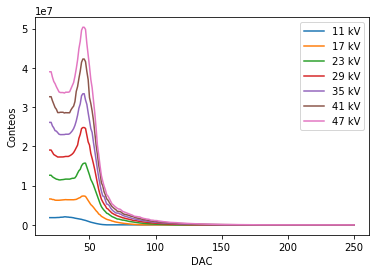

In [6]:
for i in range(filtered_tungsteno.shape[0]):
    plt.plot(DAC, filtered_tungsteno[i], label = STR_INTENSITIES[i])

plt.xlabel("DAC")
plt.ylabel("Conteos")
plt.legend()

plt.savefig("Tungsteno_Means.pdf")
plt.show()

In [7]:
fig, ax = plt.subplots()

n = 4
plots = [plt.plot([], [], label = label)[0] for label in STR_INTENSITIES]

ax.set_xlim(DAC.min(), DAC.max())
ax.set_ylim(-filtered_tungsteno.max() * 0.1, filtered_tungsteno.max() * 1.1)
def animate(i):
    l = n*i // 231
    c = n*i % 231
    plots[l].set_data(DAC[:c], filtered_tungsteno[l, :c])
    return tuple(plots)

plt.xlabel("DAC")
plt.ylabel("Conteos")
plt.legend()

ani = FuncAnimation(fig, animate, frames = np.multiply(*filtered_tungsteno.shape) // n, interval = 25)
ani.save("Tungsteno_Means.gif", writer = "imagemagick")
# plt.show()

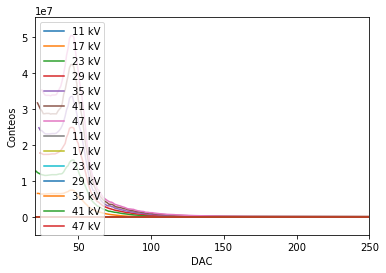

In [8]:
for i in range(normed_tungsteno.shape[0]):
    plt.plot(DAC, normed_tungsteno[i], label = STR_INTENSITIES[i])

plt.xlabel("DAC")
plt.ylabel("Conteos")
plt.legend()

plt.savefig("Tungsteno_Normed.pdf")
plt.show()

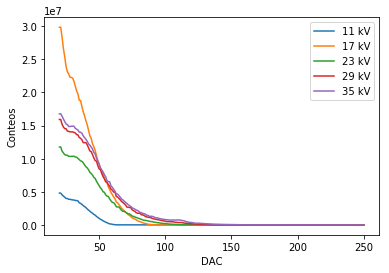

In [9]:
for i in range(filtered_plata.shape[0]):
    plt.plot(DAC, filtered_plata[i], label = STR_INTENSITIES[i])

plt.xlabel("DAC")
plt.ylabel("Conteos")
plt.legend()

plt.savefig("Plata_Means.pdf")
plt.show()

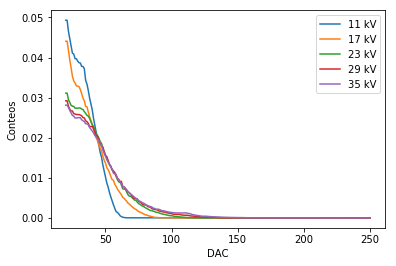

In [10]:
for i in range(normed_plata.shape[0]):
    plt.plot(DAC, normed_plata[i], label = STR_INTENSITIES[i])

plt.xlabel("DAC")
plt.ylabel("Conteos")
plt.legend()

plt.savefig("Plata_Normed.pdf")
plt.show()

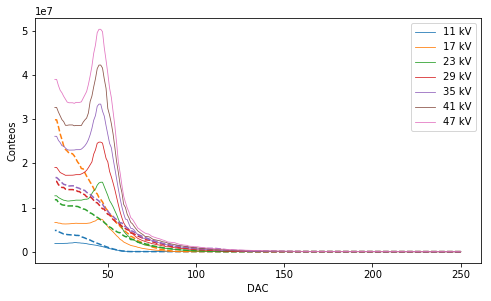

In [11]:
fig = plt.figure(figsize = (8, 4.5))
for i in range(filtered_tungsteno.shape[0]):
    c = plt.plot(DAC, filtered_tungsteno[i], label = STR_INTENSITIES[i], lw = 0.8)[0].get_color()
    try: plt.plot(DAC, filtered_plata[i], "--", c = c)
    except: pass

plt.xlabel("DAC")
plt.ylabel("Conteos")
plt.legend()

plt.savefig("Both_Means.pdf")
plt.show()

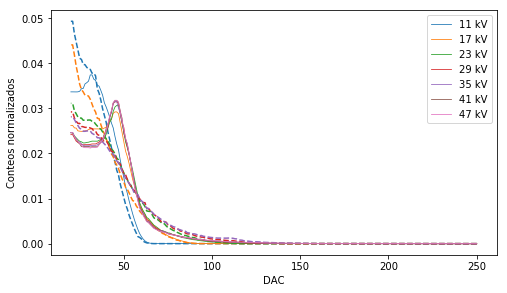

In [12]:
fig = plt.figure(figsize = (8, 4.5))
for i in range(normed_tungsteno.shape[0]):
    c = plt.plot(DAC, normed_tungsteno[i], label = STR_INTENSITIES[i], lw = 0.8)[0].get_color()
    try: plt.plot(DAC, normed_plata[i], "--", c = c)
    except: pass

plt.xlabel("DAC")
plt.ylabel("Conteos normalizados")
plt.legend()

plt.savefig("Both_Normed.pdf")
plt.show()

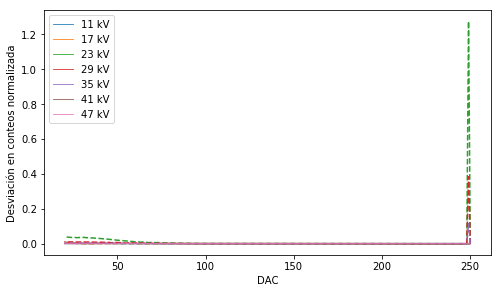

In [13]:
fig = plt.figure(figsize = (8, 4.5))
for i in range(normed_tungsteno.shape[0]):
    c = plt.plot(DAC, std_tungsteno[i], label = STR_INTENSITIES[i], lw = 0.8)[0].get_color()
    try: plt.plot(DAC, std_plata[i], "--", c = c)
    except: pass

plt.xlabel("DAC")
plt.ylabel("Desviación en conteos normalizada")
plt.legend()

plt.savefig("Both_std.pdf")
plt.show()

In [14]:
pos = filtered_tungsteno.argmax(axis = 1)
maxs = np.array([filtered_tungsteno[i, pos[i]] for i in range(len(pos))])
stds = np.array([std_tungsteno[i, pos[i]] for i in range(len(pos))])
error = stds * maxs

In [15]:
(m, b), cov = np.polyfit(INTENSITIES, maxs, 1, cov = True)
dm = cov[0, 0]**0.5
db = cov[1, 1]**0.5

y = m * INTENSITIES + b

In [16]:
print(m, dm)
print(b, db)

1382617.5 46036.8248177
-14963590.3571 1444852.38025


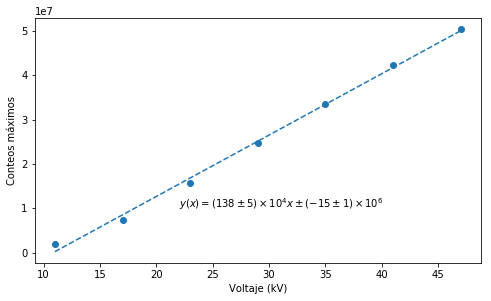

In [17]:
fig = plt.figure(figsize = (8, 4.5))
plt.errorbar(INTENSITIES, maxs, yerr = error, fmt='o', ecolor='g', capthick = 2)
plt.plot(INTENSITIES, y, "--")

plt.text(22, 10e6, r"$y(x) = (138 \pm 5)\times 10^4 x \pm (-15 \pm 1)\times 10^6$")
plt.ylabel("Conteos máximos")
plt.xlabel("Voltaje (kV)")

plt.savefig("WMax_voltage.pdf")
plt.show()